Переписать загрузку данных с python функций на Dataset и Dataloader и применить сеть с attention

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

from IPython import display
import matplotlib.pyplot as plt

In [9]:
num_samples = 2000
data_path = 'data/fra-eng/fra.txt'

In [10]:
class eng_fra_dataset(torch.utils.data.Dataset):
    def __init__(self, file_name=data_path, num_samples=num_samples, nrows=num_samples):
        
        input_vocab = set()
        output_vocab = set()

        print(f'Загружаем файл: {file_name}')
        df = pd.read_csv(data_path, sep = '\t', header = None, nrows=num_samples)
        df.rename(columns = {0 : 'eng', 1: 'fra'}, inplace = True)
        # df = df[['eng', 'fra']]
        
        input_texts = list(df['eng'])
        target_texts = list(df['fra'])
        texts = df[['eng','fra']].values.tolist()

        for input_text in input_texts:
            for word in input_text.split():
                input_vocab.add(word.strip())

        for target_text in target_texts:
            for word in target_text.split():
                output_vocab.add(word.strip())

        output_vocab = set(list(output_vocab))

        input_vocab2index = {word: i+2 for i, word in enumerate(input_vocab)}
        output_vocab2index = {word: i+2 for i, word in enumerate(output_vocab)}   
        
        self.texts = texts
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.input_vocab2index = input_vocab2index
        self.output_vocab2index = output_vocab2index
        
        print('Файл {file_name} загружен')
        
    def __len__(self):
        return len(self.input_vocab)
    
    def __getitem__(self, idx):
        return self.texts[idx]
    
    def print_ds(self):
        for i in self.input_vocab2index:
            if self.input_vocab2index[i] < 12:
                print(i, self.input_vocab2index[i])

In [11]:
def indexesFromSentence(sentence, vocab):
    return [vocab.get(word.strip(), 0) for word in sentence.split(' ')]

def tensorFromSentence(sentence, vocab):
    indexes = indexesFromSentence(sentence, vocab)
    indexes.append(1)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromSent(input_sentences, output_sentences, input_vocab2index, output_vocab2index):
    input_tensor = tensorFromSentence(input_sentences, input_vocab2index)
    target_tensor = tensorFromSentence(output_sentences, output_vocab2index)
    return (input_tensor, target_tensor)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)



In [13]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=10):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0]])

    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == 1:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
ds = eng_fra_dataset()

Загружаем файл: data/fra-eng/fra.txt
Файл {file_name} загружен


In [15]:
ds[0]

['Go.', 'Va !']

In [16]:
encoder = EncoderRNN(len(ds.input_vocab2index)+2, 30)
attn_decoder1 = AttnDecoderRNN(30, len(ds.output_vocab2index)+2, dropout_p=0.1)

encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = torch.optim.SGD(attn_decoder1.parameters(), lr=0.01)
training_pairs = np.random.randint(0, len(ds.input_texts), size=10000)
criterion = nn.NLLLoss()

print_loss_total = 0
loss_all = []

for i in range(num_samples):
    input_tensor, target_tensor = tensorsFromSent(ds.input_texts[training_pairs[i]], ds.target_texts[training_pairs[i]], \
                                                  ds.input_vocab2index, ds.output_vocab2index)

    loss = train(input_tensor, target_tensor, encoder,
               attn_decoder1, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    display.clear_output(wait=False)
    print_loss_avg = print_loss_total / 1
    loss_all.append(print_loss_avg)
    print_loss_total = 0
    print('(%d %d%%) %.4f' % (i, i / num_samples * 100, print_loss_avg))

(1999 99%) 1.7656


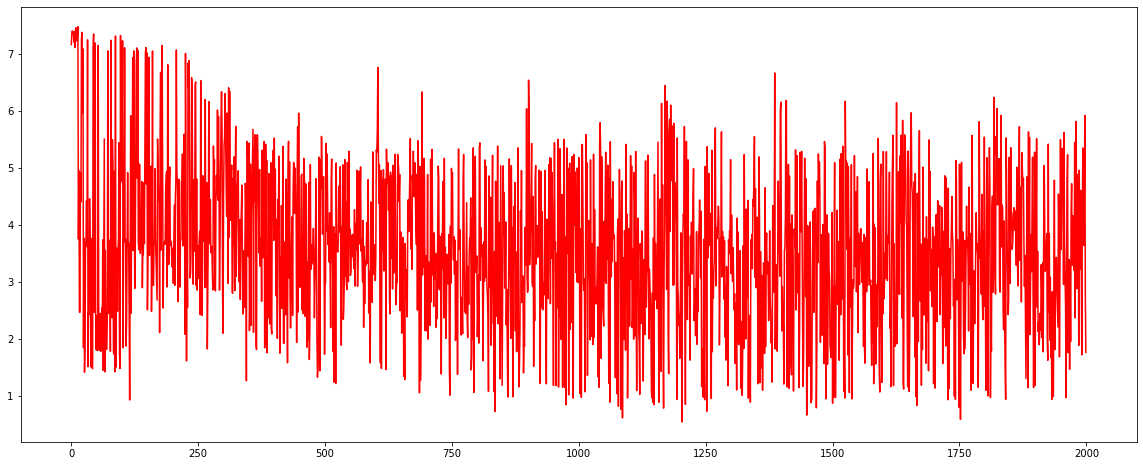

In [17]:
plt.figure(figsize=(20, 8))
plt.plot(loss_all, label='print_loss_avg', color = 'red') 